# Naive Forecast Models with Walk Forward Validation
It is important to test naive forecast models on any new prediction problem.

The results from naive models provide a quantitative idea of how difficult the forecast problem is and provide a baseline performance by which more sophisticated forecast methods can be evaluated.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import os
import statsmodels.api as sm
import math
from numpy import array
from numpy import split
from math import sqrt




from sklearn.metrics import mean_squared_error
sns.set_style("darkgrid")

In [2]:
df = pd.read_excel('counts_arrival_hour_day.xlsx')
df['date_hour_presented'] = pd.to_datetime(df['date_presented']) + df['hour_presented'] * pd.to_timedelta('1H')
df = df.set_index(['date_hour_presented'])

In [3]:
train_size=11664

In [4]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into days
    train, test = data[0:train_size], data[train_size:]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/24))
    test = array(split(test, len(test)/24))
    return train, test

In [5]:
train, test = split_dataset(df[['# arrivals']].values)

In [6]:
len(train), len(test)

(486, 244)

In [7]:
def average_forecast(history):
    avg= df[0:len(history)]['# arrivals'].mean() #only the average for training set is used
    pred = [avg for _ in range(24)]
    return pred 


def average_per_hour_forecast(history):
    average_per_hour = df[0:len(history)].groupby('hour_presented').mean()['# arrivals']
    pred = average_per_hour
    return pred 

# daily Naive model
def daily_persistence(history):
    # get the data for the prior day
    pred = history[-1]
    return pred




def evaluate_forecasts(actual, predicted):
    RMSE = list()
    # calculate an RMSE score for each hour
    for i in range(actual.shape[1]):
        # calculate mse
        rmse = sqrt(mean_squared_error(actual[:, i], predicted[:, i]))
       
        # store
        RMSE.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, RMSE





# evaluate a single model
def evaluate_model(model_func, train, test):
    # history is a list of hourly data for 24 hours
    history = [x for x in train]
    
    # walk-forward validation over each day
    predictions = list()
    for i in range(len(test)):
#         print(i)
        # predict the day
        yhat_sequence = model_func(history)
        
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next day
        history.append(test[i, :])
       
       
        
    predictions = array(predictions)
    
    
    # evaluate predictions days for each week
    score, RMSE = evaluate_forecasts(test[:, :, 0], predictions)
    s_scores = ', '.join(['%.1f' % s for s in RMSE])
    print('%s: [%.3f] %s' % (model_func, score, s_scores))
    
    
    Predictions = pd.concat([pd.DataFrame(test[-1]).rename(columns={0:'True Arrivals'}),
                             pd.DataFrame(predictions[-1]).rename(columns={0:'Naive_Predictions'}),
                             pd.DataFrame(RMSE).rename(columns={0:'Naive_RMSE'})],
                            axis=1)
#     display (Predictions)
   
    
    return Predictions, predictions, score, RMSE

<function average_forecast at 0x16375b268>: [4.666] 3.7, 4.2, 4.8, 5.3, 5.6, 5.5, 5.3, 3.8, 2.9, 3.4, 4.5, 6.4, 5.2, 5.6, 5.7, 5.0, 4.3, 4.3, 4.7, 5.0, 4.5, 3.9, 3.3, 3.1
<function daily_persistence at 0x16375b400>: [4.178] 4.1, 3.4, 3.6, 3.1, 3.0, 2.6, 2.9, 3.5, 3.8, 4.5, 4.2, 5.5, 4.4, 4.7, 5.1, 4.5, 4.0, 4.2, 4.9, 4.5, 4.9, 4.3, 4.2, 4.7
<function average_per_hour_forecast at 0x16375b378>: [3.121] 3.0, 2.5, 2.7, 2.2, 2.3, 2.0, 2.2, 2.6, 2.8, 3.3, 3.1, 4.0, 3.3, 3.4, 3.7, 3.3, 3.0, 3.3, 3.9, 3.4, 4.0, 3.3, 3.1, 3.2


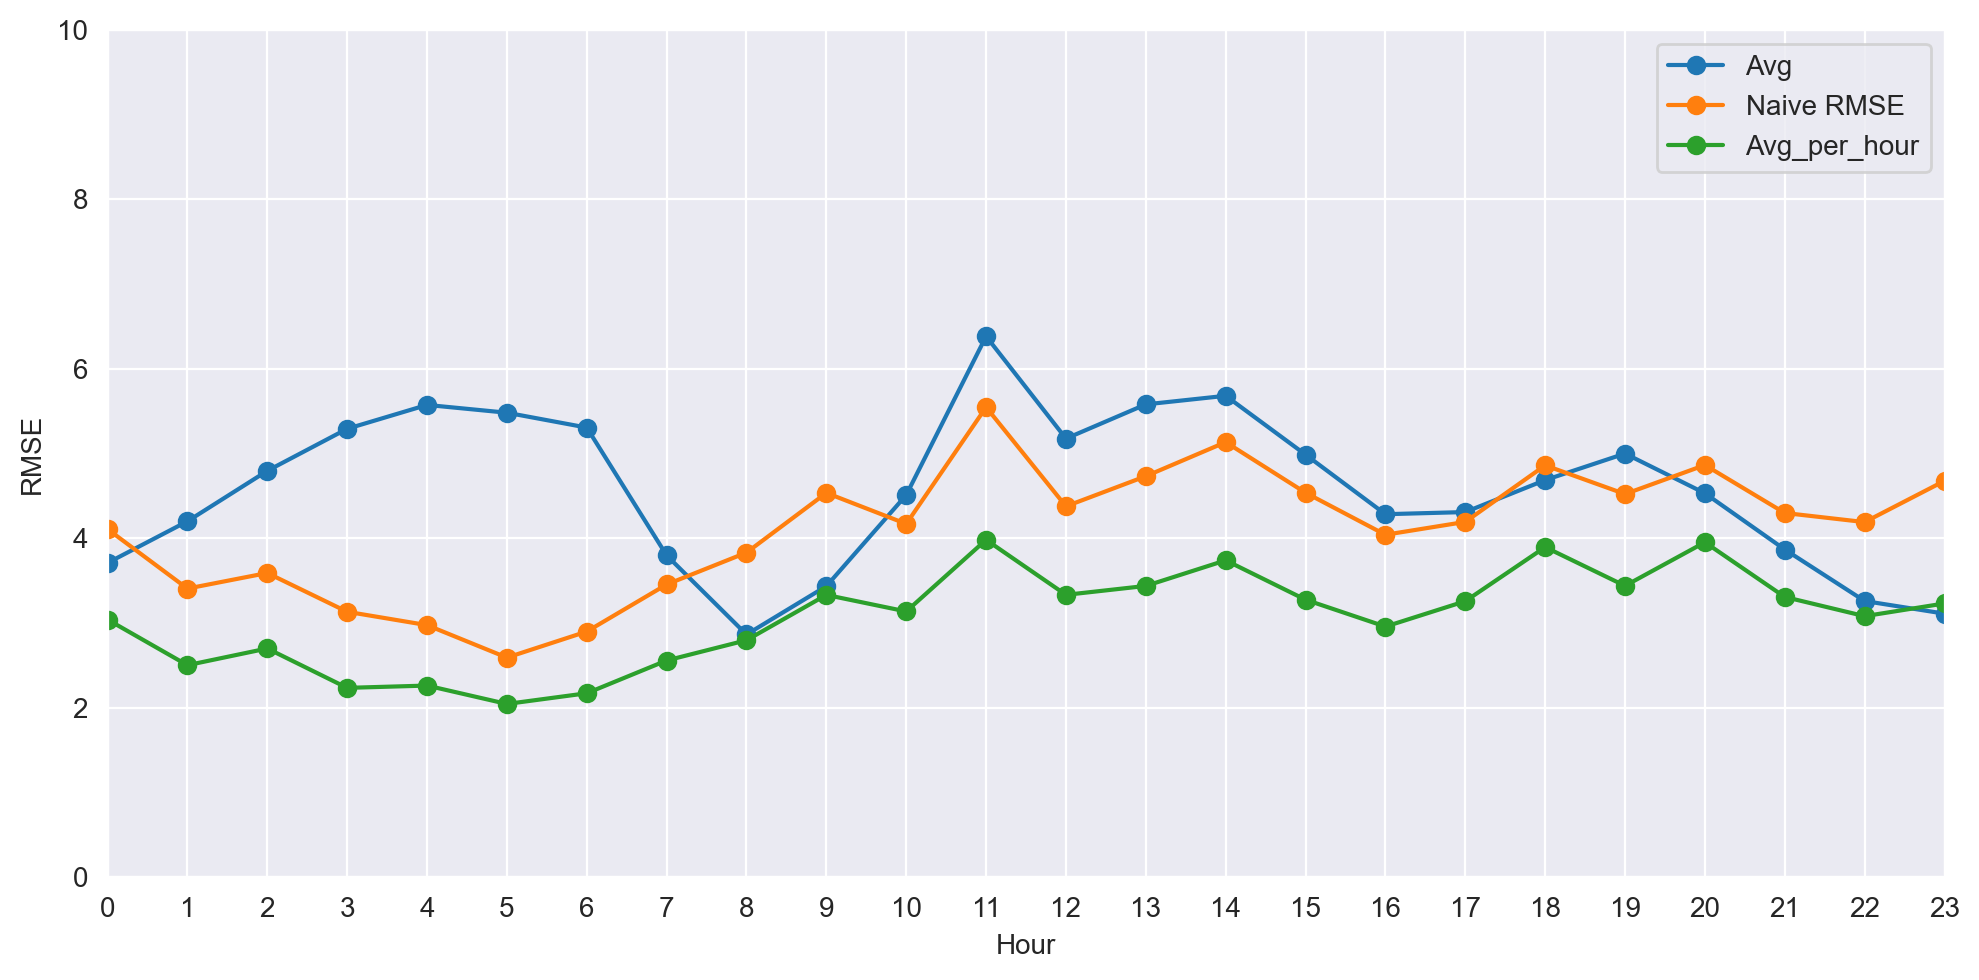

In [8]:
models = dict()
# models['Hourly Naive RMSE'] = hourly_persistence
models['Avg']  = average_forecast
models['Naive RMSE'] = daily_persistence
models['Avg_per_hour']  = average_per_hour_forecast


# models['SMA']  = daily_SMA





fig, ax=plt.subplots(1,1, figsize=(10,5), dpi=200)
hours = list(range(0,24))
for name, func in models.items():
    # evaluate and get scores
    Predictions, predictions, score, RMSE = evaluate_model(func, train, test)
    
    
#     plt.plot(Predictions['True Arrivals'], label='True Arrivals')
#     plt.plot(Predictions['Predictions'], label='Naive Predictions')
    
    
    
    #plot scores
#     fig, ax=plt.subplots(1,1, figsize=(10,5), dpi=200)
    plt.plot(hours, RMSE, marker='o', label=name)
    plt.xticks(list(range(0,24)))
    plt.ylim([0,10])
    plt.ylabel('RMSE')
    plt.xlabel('Hour')
    plt.margins(0)
    plt.tight_layout()
    plt.legend();
    
plt.savefig('Naive_walk forward.jpg', dpi=200)